In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import statsmodels.formula.api as smf

# <font face="gotham" color="purple"> Techniques For Handling Time Series Data </font>

This section aims to introduce the most fundamental skills of wrangling time series data in Python, specifically with Pandas.

## <font face="gotham" color="purple"> Why Taking Logs?</font>

If the time series that exhibit any traces of growth or decline, i.e. nonstationary, a useful transformation is to take natural logarithm of it. Suppose if $y_t$ is an observation of the time series in period $t$, the growth rate from period $t-1$ is
$$
g_t = \frac{y_t}{y_{t-1}}-1
$$
where $g_t$ is the growth rate. Rearrange and take natural log
$$
\ln{(1+g_t)}=\ln{\bigg(\frac{y_t}{y_{t-1}}\bigg)}=\ln{y_t}-\ln{y_{t-1}}
$$
So the question is what is $\ln{(1+g_t)}$?

In calculus class, we have learned **Taylor Expansion**, which is the ultimate weapon for approximate any functions. 
$$
\ln (1+x)=x-\frac{1}{2} x^{2}+\frac{1}{3} x^{3}-\frac{1}{4} x^{4}+\ldots=\sum_{k=1}^\infty(-1)^{k+1}\frac{x^k}{k}
$$

Because the growth rate is usually small, we can use the linear term exclusively in Taylor expansion
$$
\ln{(1+x)}\approx x
$$
which means log difference approximates the growth rate
$$
\ln{y_t}-\ln{y_{t-1}} \approx g_t
$$

Let's take a look at real GDP per capita from US.

In [213]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2021,10, 1)
df = pdr.data.DataReader(['A939RX0Q048SBEA'], 'fred' , start, end)
df.columns = ['R_GDP_PerCap']
df['R_GDP_PerCap_tm1'] = df['R_GDP_PerCap'].shift(1)
df = df.dropna()
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1
DATE,,
1950-04-01,14889.0,14500.0
1950-07-01,15398.0,14889.0
1950-10-01,15623.0,15398.0
1951-01-01,15769.0,15623.0
1951-04-01,15979.0,15769.0


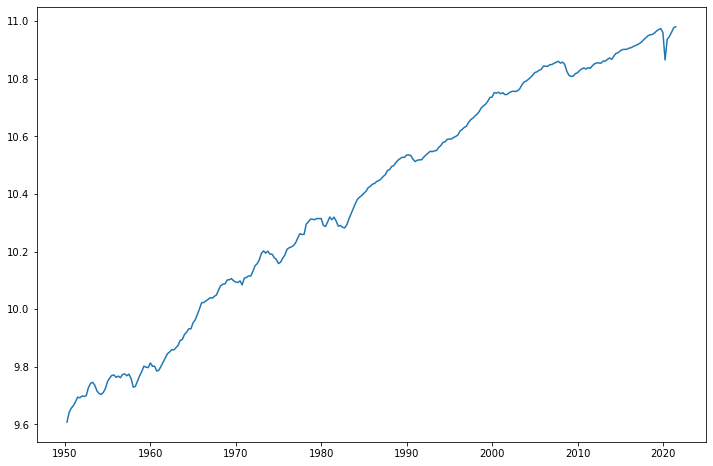

In [190]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(np.log(df['R_GDP_PerCap']))

In [187]:
pd.options.mode.chained_assignment = None # without this, there will be error msg 'A value is trying to be set on a copy of a slice from a DataFrame.'
df['Gr_rate'] = df['R_GDP_PerCap']/df['R_GDP_PerCap_tm1']
df['Gr_rate'] = df['Gr_rate']-1
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate
DATE,,,
1950-04-01,14889.0,14500.0,0.026828
1950-07-01,15398.0,14889.0,0.034186
1950-10-01,15623.0,15398.0,0.014612
1951-01-01,15769.0,15623.0,0.009345
1951-04-01,15979.0,15769.0,0.013317


In [188]:
df['Gr_rate_log_approx'] = np.log(df['R_GDP_PerCap']) - np.log(df['R_GDP_PerCap_tm1'])
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx
DATE,,,,
1950-04-01,14889.0,14500.0,0.026828,0.026474
1950-07-01,15398.0,14889.0,0.034186,0.033615
1950-10-01,15623.0,15398.0,0.014612,0.014507
1951-01-01,15769.0,15623.0,0.009345,0.009302
1951-04-01,15979.0,15769.0,0.013317,0.013229


This charts shows the difference between division growth rate $g_t = \frac{y_t}{y_{t-1}}-1$ and log difference growth rate $g_t\approx \ln{y_t}-\ln{y_{t-1}} $

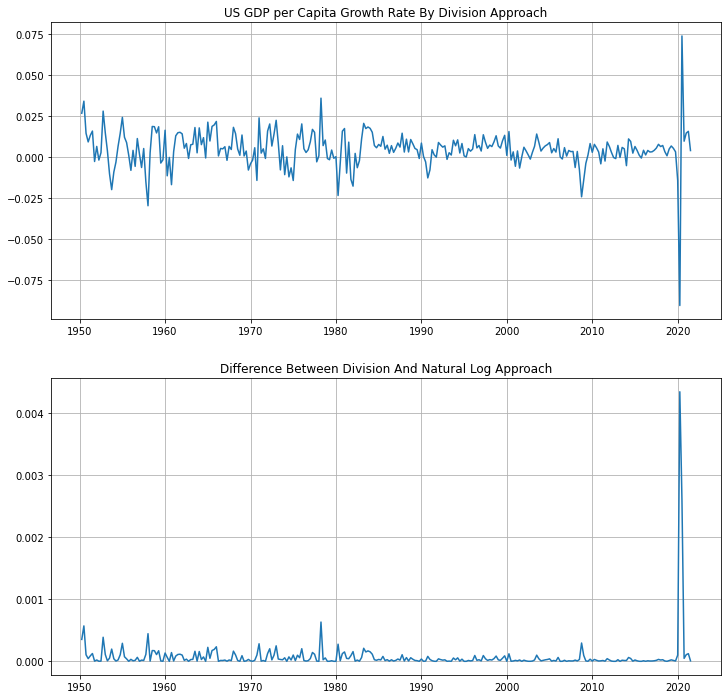

In [195]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))
ax[0].plot(df['Gr_rate'])
ax[0].grid()
ax[0].set_title('US GDP per Capita Growth Rate By Division Approach')
ax[1].plot(df['Gr_rate']- df['Gr_rate_log_approx'])
ax[1].grid()
ax[1].set_title('Difference Between Division And Natural Log Approach')
plt.show()

In [201]:
max(df['Gr_rate'])

0.07393814275337385

In [200]:
max(df['Gr_rate_log_approx'])

0.0713323992263053

As you can see from log difference growth rate will consistently underestimate the growth rate, however the differences are negligible, mostly difference are under $5$ basis points, especially post 1980s period, the log difference grow rate approximate real growth rate considerably well. The only exception is the rebound during Covid pandemic, more than $40$ basis points ($0.04\%$).

## <font face="gotham" color="purple"> How Reliable Is The Natural Log Transformation?</font>

We create a series from $0$ to $.8$ with step of $.01$, which means the growth rate ranging from $0\%$ to $80
\%$ with step of $1\%$. The first plot is the comparison of division and natural log approach, as they increase the discrepancy grow bigger too, the second plot is the difference of two approaches, if the growth rate is less than $20\%$, the error of natural log approach is acceptable.

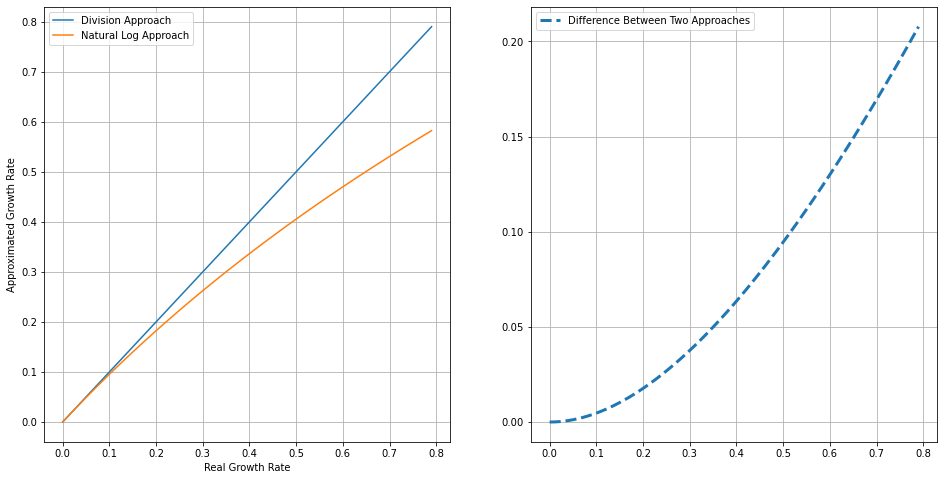

In [192]:
g = np.arange(0, .8, .01)
log_g = np.log(1+g)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 8))
ax[0].plot(g, g, label = 'Division Approach')
ax[0].plot(g, log_g, label = 'Natural Log Approach')
ax[0].set_xlabel('Real Growth Rate')
ax[0].set_ylabel('Approximated Growth Rate')
ax[0].grid()
ax[0].legend()

ax[1].plot(g, g - log_g, ls = '--', lw = 3, label = 'Difference Between Two Approaches')
ax[1].grid()
ax[1].legend()
plt.show()

## <font face="gotham" color="purple"> How To Calculate YoY growth rate? </font>

What we have seen above is **Quarter on Quarter** (QoQ) growth rate, another common way of measuring growth is **Year over Year**. 

If you still using quarterly data, it's simply 
$$
g_{YoY, 2021}=\frac{y_{3Q2021}}{y_{3Q2020}}-1
$$
where $y_{3Q2021}$ is the observation on the $3$rd quarter of $2021$, similarly $y_{3Q2020}$ is from the $3$rd quarter of $2020$.

In [207]:
df['R_GDP_PerCap_tm4'] = df['R_GDP_PerCap'].shift(4)
df = df.dropna()
df

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4
DATE,,,,,
1951-04-01,15979.0,15769.0,0.013317,0.013229,14889.0
1951-07-01,16234.0,15979.0,0.015958,0.015832,15398.0
1951-10-01,16192.0,16234.0,-0.002587,-0.002591,15623.0
1952-01-01,16299.0,16192.0,0.006608,0.006586,15769.0
1952-04-01,16271.0,16299.0,-0.001718,-0.001719,15979.0
...,...,...,...,...,...
2020-07-01,56182.0,52314.0,0.073938,0.071332,58141.0
2020-10-01,56732.0,56182.0,0.009790,0.009742,58333.0
2021-01-01,57568.0,56732.0,0.014736,0.014628,57512.0


In [208]:
df['Gr_rate_log_approx_YoY'] = np.log(df['R_GDP_PerCap']) - np.log(df['R_GDP_PerCap_tm4'])
df.head()

,R_GDP_PerCap,R_GDP_PerCap_tm1,Gr_rate,Gr_rate_log_approx,R_GDP_PerCap_tm4,Gr_rate_log_approx_YoY
DATE,,,,,,
1951-04-01,15979.0,15769.0,0.013317,0.013229,14889.0,0.070653
1951-07-01,16234.0,15979.0,0.015958,0.015832,15398.0,0.052870
1951-10-01,16192.0,16234.0,-0.002587,-0.002591,15623.0,0.035773
1952-01-01,16299.0,16192.0,0.006608,0.006586,15769.0,0.033058
1952-04-01,16271.0,16299.0,-0.001718,-0.001719,15979.0,0.018109


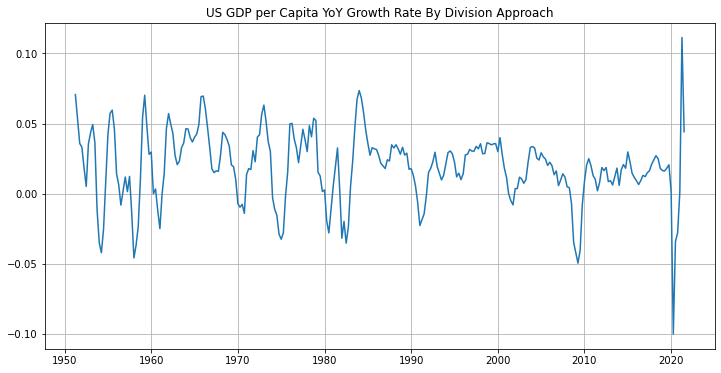

In [212]:
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(df['Gr_rate_log_approx_YoY'])
ax.grid()
ax.set_title('US GDP per Capita YoY Growth Rate By Division Approach')
plt.show()

## <font face="gotham" color="purple"> How to Resample Time Series? </font>

By **resampling**, we can **upsample** the series, i.e. convert to higher frequency series, or we can **downsample** the series, i.e. convert to lower frequency series.

For example, you have one series of lower frequency, say annually, but the rest of series are quarterly, in order to incorporate this annual series into the whole dataset, we have to upsample it to quarterly data.

Now we import nominal annual GDP per capita.

In [215]:
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2021,10, 1)
df = pdr.data.DataReader(['A939RC0A052NBEA'], 'fred' , start, end)
df.columns = ['Nom_GDP_PerCap_Annual']
df = df.dropna()
df.head()

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.0
1951-01-01,2248.0
1952-01-01,2340.0
1953-01-01,2439.0
1954-01-01,2405.0


In [227]:
df.resample('QS').mean().fillna('bfill') # QS mean quarter start freq

,Nom_GDP_PerCap_Annual
DATE,
1950-01-01,1977.0
1950-04-01,bfill
1950-07-01,bfill
1950-10-01,bfill
1951-01-01,2248.0
...,...
2019-01-01,65056.0
2019-04-01,bfill
2019-07-01,bfill


In [222]:
df.resample?

Signature:
df.resample(
    rule,
    axis=0,
    closed: 'Optional[str]' = None,
    label: 'Optional[str]' = None,
    convention: 'str' = 'start',
    kind: 'Optional[str]' = None,
    loffset=None,
    base: 'Optional[int]' = None,
    on=None,
    level=None,
    origin: 'Union[str, TimestampConvertibleTypes]' = 'start_day',
    offset: 'Optional[TimedeltaConvertibleTypes]' = None,
) -> 'Resampler'
Docstring:
Resample time-series data.

Convenience method for frequency conversion and resampling of time
series. Object must have a datetime-like index (`DatetimeIndex`,
`PeriodIndex`, or `TimedeltaIndex`), or pass datetime-like values
to the `on` or `level` keyword.

Parameters
----------
rule : DateOffset, Timedelta or str
    The offset string or object representing target conversion.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Which axis to use for up- or down-sampling. For `Series` this
    will default to 0, i.e. along the rows. Must be
    `DatetimeIndex`, `TimedeltaInd

# <font face="gotham" color="purple"> Dynamic Econometric Models </font>

After discussions of autocorrelation, we are officially entering the realm of time series econometrics. For starter, we will discuss dynamic econometric models: **distributed-lag model** and **autogressive model**. 

In economics and finance, dependent variables and explanatory (independent) variables are rarely instantaneous, i.e. $Y$ responds to $X$'s with a lapse of time.

## <font face="gotham" color="purple"> Distributed-Lag Model (DLM) </font>

Here is a DLM with one explanatory variable $X$
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{1} X_{t-1}+\beta_{2} X_{t-2}+\cdots+u_{t}
$$

### <font face="gotham" color="purple"> Ad Hoc Estimation Of DLM </font>

If you are estimating variables which have no clear economic relationship or no well-founded theoretical support, go with ad hoc estimation method. 

So you start regressing $X_t$ onto $Y_t$, then adding $X_{t-i}$ where $i \geq 1$ in each round of regression, until $t$-statistic starting to be insignificant or signs of coefficients start to be unstable.

\begin{align}
\hat{Y}_t &= a + b_0X_t\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_2X_{t-2}\\
\hat{Y}_t &= a + b_0X_t+b_1X_{t-1}+b_1X_{t-1}+b_3X_{t-3}\\
\end{align}

But be aware that ad hoc method is bring significant problem of multicollinearity. 

### <font face="gotham" color="purple"> Koyck Approach To DLM </font>

Koyck approach assumes that all $\beta$'s are of the same sign, furthermore
$$
\beta_{k}=\beta_{0} \lambda^{k} \quad k=0,1, \ldots
$$
where $\lambda$ is the _rate of decay_, $0<\lambda<1$.

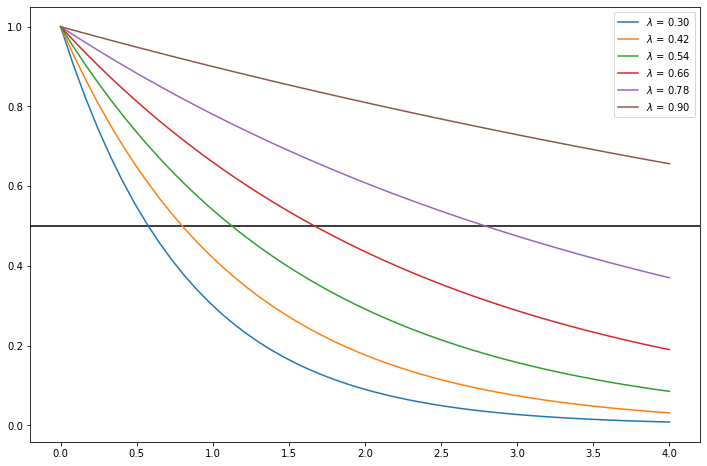

In [41]:
lamda = np.linspace(0.3, .9, 6)
beta_0 = 1
k = np.linspace(0, 4)
fig, ax = plt.subplots(figsize = (12, 8))
for i in lamda:
    beta_k = beta_0*i**k
    ax.plot(k, beta_k, label = '$\lambda$ = %.2f'%i)
ax.legend()
ax.axhline(y = 0.5, zorder = -10, color = 'k')
plt.show()

There are three perks of Koyck approach:

1. By assuming nonnegative values for $λ$, $\beta$'s sign are stable; 
2. by assuming $λ < 1$, lesser weight is given to the distant $β$'s than the current ones; 
3. The sum of the $β$'s, which gives the long-run multiplier, is finite, i.e.
$$
\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)
$$

Naturally, the infinite distributed lag  model can be rewritten as
$$
Y_{t}=\alpha+\beta_{0} X_{t}+\beta_{0} \lambda X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\cdots+u_{t}
$$

Lag both sides one period
$$
Y_{t-1}=\alpha+\beta_{0} X_{t-1}+\beta_{0} \lambda X_{t-2}+\beta_{0} \lambda^{2} X_{t-3}+\cdots+u_{t-1}
$$

Multiply by $\lambda$
$$
\lambda Y_{t-1}=\lambda \alpha+\lambda \beta_{0} X_{t-1}+\beta_{0} \lambda^{2} X_{t-2}+\beta_{0} \lambda^{3} X_{t-3}+\cdots+\lambda u_{t-1}
$$
Join with original equation
$$
Y_{t}-\lambda Y_{t-1}=\alpha(1-\lambda)+\beta_{0} X_{t}+\left(u_{t}-\lambda u_{t-1}\right)
$$

Rearrange, we obtain
$$
Y_{t}=\alpha(1-\lambda)+\beta_{0} X_{t}+\lambda Y_{t-1}+v_{t}
$$
where $v_t = (u_t − λu_{t−1})$.

This is called **Koyck transformation** which simplifies original infinite DLM into an $AR(1)$.

### <font face="gotham" color="purple"> An Example Of Consumption And Income </font>

We import macro data from FRED, $PCE$ is _real personal consumption expenditure_ and $DI$ is _real disposable income per capita_. 

In [105]:
start = dt.datetime(2002, 1, 1)
end = dt.datetime(2021,10, 1)
df_exp = pdr.data.DataReader(['PCEC96','A229RX0'], 'fred' , start, end)
df_exp.columns = ['PCE', 'DI']
df_exp = df_exp.dropna()
df_exp.head()

,PCE,DI
DATE,,
2002-01-01,9004.4,34707.0
2002-02-01,9040.1,34735.0
2002-03-01,9038.2,34734.0
2002-04-01,9086.5,34827.0
2002-05-01,9051.4,34941.0


Define a function for lagging, which is handy in $R$-style formula.

In [106]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 
    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

The model is 
$$
PCE_t = \alpha(1-\lambda) + \beta_0 DI_t + \lambda PCE_{t-1}+ v_t
$$

In [107]:
DLM = smf.ols(formula = 'PCE ~ 1 + lag(DI, 0) + lag(PCE, 1)', data = df_exp)
DLM_results = DLM.fit()
print(DLM_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    PCE   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     7861.
Date:                Thu, 28 Oct 2021   Prob (F-statistic):          7.29e-214
Time:                        10:52:27   Log-Likelihood:                -1503.8
No. Observations:                 235   AIC:                             3014.
Df Residuals:                     232   BIC:                             3024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -109.1320    103.256     -1.057      

The estimated results:

In [108]:
beta_0 = DLM_results.params[1]
lamda = DLM_results.params[2]
alpha = DLM_results.params[0]/(1-DLM_results.params[2])

print('beta_0 = {}'.format(beta_0))
print('lambda = {}'.format(lamda))
print('alpha = {}'.format(alpha))

beta_0 = 0.02292255662377629
lambda = 0.9294829077279697
alpha = -1547.59673970508


Any $\beta_k$ is given by $\beta_{k}=\beta_{0} \lambda^{k}$

In [109]:
def beta_k(lamda, k, beta_0):
    return beta_0 * lamda**k

In [110]:
beta_k(lamda, 1, beta_0)

0.02130612458322662

The long run multiplier given by $\sum_{k=0}^{\infty} \beta_{k}=\beta_{0}\left(\frac{1}{1-\lambda}\right)$

In [111]:
beta_0*(1/(1-lamda))

0.32506383750692786

In [90]:
1/(1-lamda)

14.180959080705563

Median lag, the lags that it takes to decay the first half. From our example, that $PCE$ adjusts to $DI$ with substantial lag, around $9$ month to have half impact.

In [112]:
-np.log(2)/np.log(lamda)

9.478694617455716

Mean lag

In [113]:
lamda/(1-lamda)

13.180959080705563

# <font face="gotham" color="purple"> Stochastic Processes </font>

Unstrictly speaking, **stochastic processes** is a subject of mathematics that studies a family of random variables which are indexed by time. Since time series data is a series of **realization** of a stochastic process, before investigating further, we will introduce some basic concepts of stochastic processes.

For instance, we denote $GDP$ as $Y_t$ which is a stochastic process, therefore $Y_1$ and $Y_2$ are two different random variables, if $Y_1 = 12345$, then it is a realization of $t_1$. You can think of stochastic process as population and realization as sample as in cross-sectional data.

## <font face="gotham" color="purple"> Stationary Stochastic Processes </font>

A stochastic process is said to be **stationary** if its mean and variance are constant over time and the value of the covariance between the two time periods depends only on the distance $k$ between the two time periods and not the actual time at which the covariance is computed. Mathematically, a **weak stationary process** should satisfy three conditions:

\begin{align}
Mean:& \quad E\left(Y_{t}\right)=\mu\\
Variance:&\quad E\left(Y_{t}-\mu\right)^{2}=\sigma^{2}\\
Covariance:&\quad E\left[\left(Y_{t}-\mu\right)\left(Y_{t+k}-\mu\right)\right] = \gamma_{k}
\end{align}

Most of time weak stationary process will suffice, rarely we require a process to be **strong stationary** which means all moments are **time-invariant**. 